In [1]:
# ASL Recognition Project using CNN and Transfer Learning

## 1. Import Libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
print("✅ Import tất cả các thư viện xong!")

2025-11-01 08:09:13.367004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761984553.562608      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761984553.617281      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Import tất cả các thư viện xong!


In [2]:
## 2. Dataset Paths
train_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

In [3]:
## 3. EDA – Thống kê dữ liệu
classes = sorted(os.listdir(train_dir))
print(f"Tổng số lớp ASL: {len(classes)}")
print(f"Danh sách lớp: {classes}")

Tổng số lớp ASL: 29
Danh sách lớp: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Tổng số lớp: 29


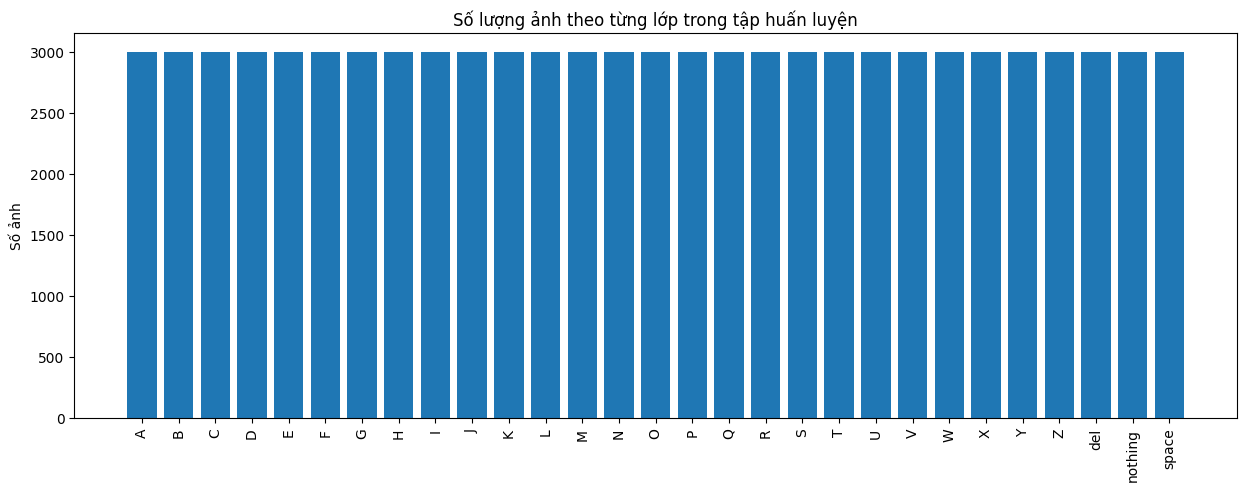

In [4]:
classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"Tổng số lớp: {len(classes)}")

class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

plt.figure(figsize=(15, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Số lượng ảnh theo từng lớp trong tập huấn luyện")
plt.xticks(rotation=90)
plt.ylabel("Số ảnh")
plt.show()

In [5]:
## 4. Tiền xử lý dữ liệu
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [6]:
## 5–7. Xây dựng mô hình CNN, MobileNetV2, ResNet50
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
print("✅ Done CNN!")

✅ Done CNN!


In [7]:
def build_mobilenet():
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
print("✅ Done Mobilenet!")

✅ Done Mobilenet!


In [8]:
def build_resnet():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
print("✅ Done Resnet!")

✅ Done Resnet!


In [9]:
## 8. Huấn luyện, lưu và ghi log mô hình
models_dict = {
    "SimpleCNN": build_simple_cnn(),
    "MobileNetV2": build_mobilenet(),
    "ResNet50": build_resnet()
}

history_dict = {}
val_accuracies = {}
training_times = {}

for name, model in models_dict.items():
    print(f"\n====== Huấn luyện mô hình: {name} ======")
    start = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10
    )
    end = time.time()
    
    history_dict[name] = history
    val_accuracies[name] = max(history.history['val_accuracy'])
    training_times[name] = end - start
    model.save(f"asl_model_{name}.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761984605.364468      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761984605.365210      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

====== Huấn luyện mô hình: SimpleCNN ======


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1761984613.160453      74 service.cc:148] XLA service 0x7d6d6c807240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761984613.161241      74 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761984613.161264      74 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761984613.451604      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2175 ━━━━━━━━━━━━━━━━━━━━ 4:44:26 8s/step - accuracy: 0.0000e+00 - loss: 3.3877

I0000 00:00:1761984618.170502      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1205s 551ms/step - accuracy: 0.3980 - loss: 2.0693 - val_accuracy: 0.4767 - val_loss: 1.8283
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 953s 438ms/step - accuracy: 0.8799 - loss: 0.3678 - val_accuracy: 0.5657 - val_loss: 1.5920
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 965s 443ms/step - accuracy: 0.9332 - loss: 0.2015 - val_accuracy: 0.5820 - val_loss: 1.8343
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 942s 433ms/step - accuracy: 0.9548 - loss: 0.1370 - val_accuracy: 0.6094 - val_loss: 1.6934
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 948s 436ms/step - accuracy: 0.9622 - loss: 0.1105 - val_accuracy: 0.6267 - val_loss: 1.6354
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 954s 438ms/step - accuracy: 0.9724 - loss: 0.0862 - val_accuracy: 0.6137 - val_loss: 1.8507
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 968s 445ms/step - accuracy: 0.9748 - loss: 0.0784 - val_accuracy: 0.6430 - val_loss: 2.0891
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1000s 460ms/step - accuracy: 0

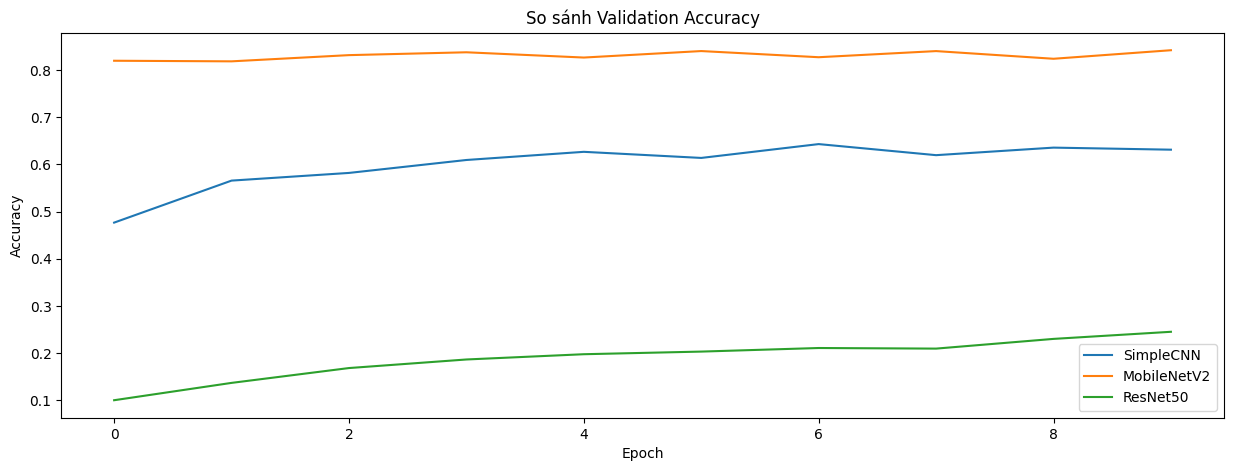

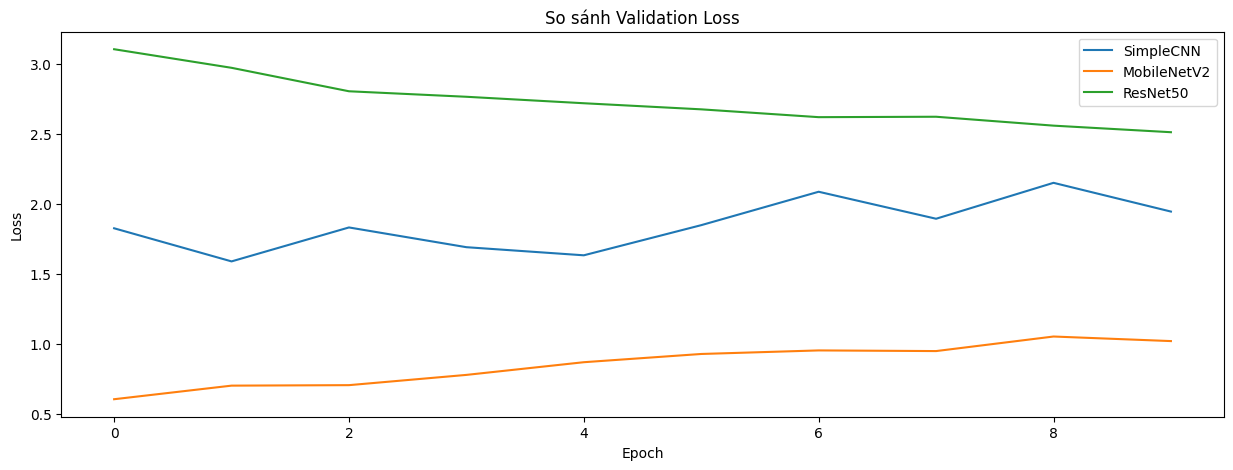

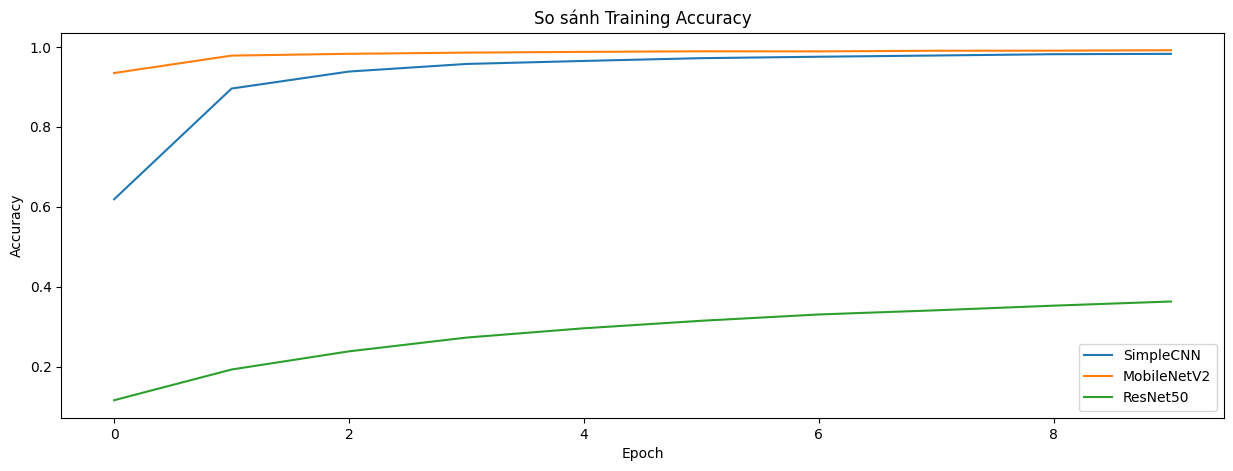

In [10]:
## 9. So sánh mô hình bằng biểu đồ
plt.figure(figsize=(15, 5))
for name, history in history_dict.items():
    plt.plot(history.history['val_accuracy'], label=f'{name}')
plt.title('So sánh Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
for name, history in history_dict.items():
    plt.plot(history.history['val_loss'], label=f'{name}')
plt.title('So sánh Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
for name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f'{name}')
plt.title('So sánh Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
## 10. Log mô hình tốt nhất
best_model = max(val_accuracies, key=val_accuracies.get)
print(f"\n✅ Mô hình tốt nhất là: {best_model} với Validation Accuracy = {val_accuracies[best_model]:.4f}")
print(f"⏱️ Thời gian huấn luyện: {training_times[best_model]:.2f} giây")


✅ Mô hình tốt nhất là: MobileNetV2 với Validation Accuracy = 0.8420
⏱️ Thời gian huấn luyện: 9680.85 giây


In [12]:
## 11. Confusion Matrix & Classification Report cho mô hình tốt nhất
print("\n🔍 Đánh giá chi tiết mô hình tốt nhất:")
from tensorflow.keras.models import load_model
model_best = load_model(f"asl_model_{best_model}.h5")


🔍 Đánh giá chi tiết mô hình tốt nhất:


In [13]:
# Dự đoán
val_generator.reset()
y_true = val_generator.classes
y_pred = model_best.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

544/544 ━━━━━━━━━━━━━━━━━━━━ 208s 376ms/step


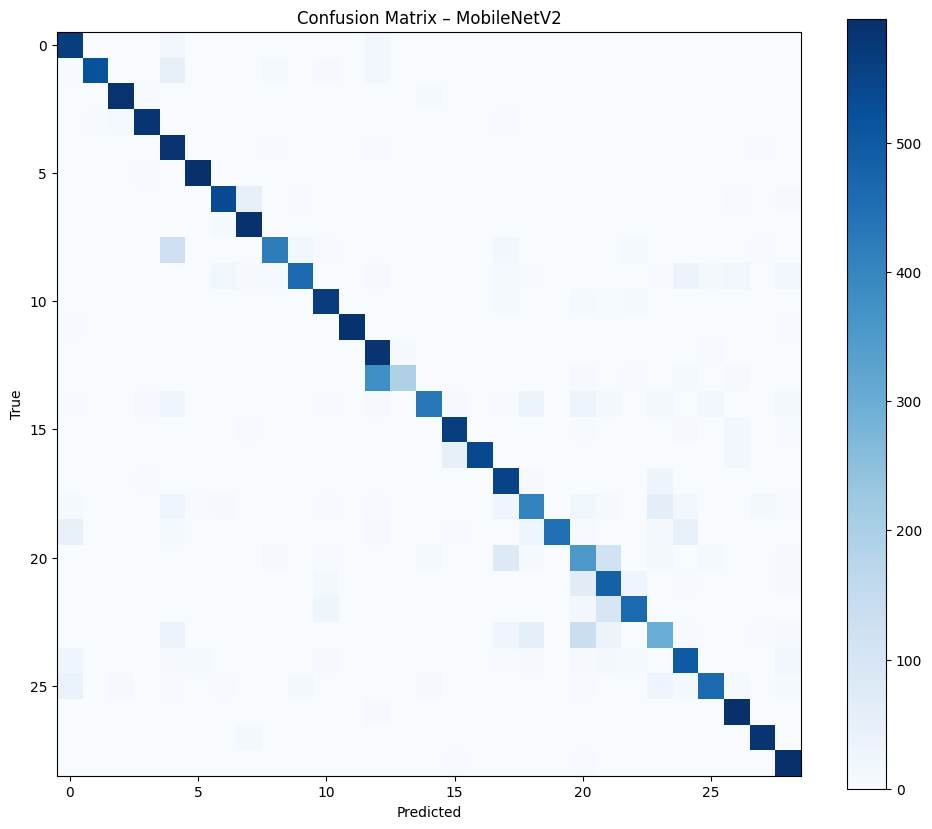

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
plt.imshow(cm, cmap='Blues')
plt.title(f'Confusion Matrix – {best_model}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

In [15]:
# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

              precision    recall  f1-score   support

           A       0.81      0.94      0.87       600
           B       0.99      0.86      0.92       600
           C       0.98      0.98      0.98       600
           D       0.96      0.97      0.97       600
           E       0.66      0.98      0.79       600
           F       0.98      0.99      0.99       600
           G       0.93      0.90      0.91       600
           H       0.90      0.98      0.94       600
           I       0.92      0.70      0.80       600
           J       0.92      0.77      0.84       600
           K       0.90      0.94      0.92       600
           L       1.00      0.98      0.99       600
           M       0.57      0.97      0.72       600
           N       0.96      0.32      0.48       600
           O       0.95      0.72      0.82       600
           P       0.90      0.94      0.92       600
           Q       0.99      0.90      0.94       600
           R       0.76    

In [16]:
## 12. Tổng kết nghiên cứu mô hình
print("\n📊 So sánh tổng quan các mô hình:")
for name in models_dict:
model = models_dict[name]
total_params = model.count_params()
best_val_acc = val_accuracies[name]
train_time = training_times[name]


print(f"\n📌 Mô hình: {name}")
print(f" - Tổng tham số học: {total_params:,}")
print(f" - Val Accuracy cao nhất: {best_val_acc:.4f}")
print(f" - Thời gian huấn luyện: {train_time:.2f} giây")


# Nhận xét mô hình
if name == "SimpleCNN":
print(" → Mô hình đơn giản, ít tham số, dễ overfit, nhưng dễ kiểm soát")
elif name == "MobileNetV2":
print(" → Nhẹ, nhanh, phù hợp cho ứng dụng thực tế, độ chính xác tốt")
elif name == "ResNet50":
print(" → Mạnh mẽ, học được đặc trưng phức tạp, nhưng nặng và tốn thời gian")

IndentationError: expected an indented block after 'for' statement on line 3 (1568916871.py, line 4)

In [ ]:
## 13. Ghi nhận F1-score từng lớp
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, zero_division=0)


print("\n📋 F1-score từng lớp:")
for i, label in enumerate(val_generator.class_indices):
print(f"{label:10s} – Precision: {precision[i]:.2f} | Recall: {recall[i]:.2f} | F1-score: {f1[i]:.2f}")

In [ ]:
## 14. Fine-tuning lại MobileNetV2 (tầng cuối)
print("\n🚧 Tiến hành Fine-tuning tầng cuối MobileNetV2...")
base_finetune = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_finetune.trainable = True


# Chỉ fine-tune 30% cuối cùng của mô hình
fine_tune_at = int(len(base_finetune.layers) * 0.7)
for layer in base_finetune.layers[:fine_tune_at]:
layer.trainable = False


model_finetune = models.Sequential([
base_finetune,
layers.GlobalAveragePooling2D(),
layers.Dense(256, activation='relu'),
layers.Dropout(0.4),
layers.Dense(len(classes), activation='softmax')
])


model_finetune.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
loss='categorical_crossentropy',
metrics=['accuracy']
)


history_finetune = model_finetune.fit(
train_generator,
validation_data=val_generator,
epochs=10
)


# Đánh giá mô hình fine-tune
val_acc_finetune = max(history_finetune.history['val_accuracy'])
print(f"\n✅ MobileNetV2 Fine-tuned đạt val_acc = {val_acc_finetune:.4f}")

In [ ]:
## 15. Phân tích học thuật – Gợi ý cải tiến nghiên cứu
print("\n📚 Phân tích học thuật:")
print("- CNN cơ bản có ưu điểm dễ kiểm soát, nhưng dễ bị overfitting nếu không tăng cường dữ liệu.")
print("- Transfer learning giúp tận dụng kiến thức từ ImageNet, hiệu quả vượt trội khi dữ liệu hạn chế.")
print("- Fine-tuning các tầng cuối của MobileNetV2 giúp mô hình học thêm đặc trưng phù hợp với ASL.")
print("- F1-score giữa các lớp chỉ ra lớp nào đang dễ bị nhầm lẫn → cơ sở cải thiện về augmentation hoặc kiến trúc.")
print("- Có thể mở rộng nghiên cứu bằng cách dùng LSTM kết hợp CNN để nhận diện động tác ASL dạng video hoặc chuỗi ảnh.")